<a href="https://colab.research.google.com/github/tiasnyder/PHYS250/blob/main/Tia_Snyder_PHYS250_midterm_project_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Physics: Midterm Project 2024

### Overview
This project focuses on golf and, more specifically, the challenges presented by the par-3 [12th hole at Augusta National Golf Course](https://www.todays-golfer.com/news-and-events/majors/the-masters/augusta-course-guide/#12).


This hole is described as the scariest par-3 on the PGA tour, and for good reason.  
* The green is relatively small and is surrounded by hazards.
* The wind is variable and difficult to judge from the tee.


### Definition of Coordinate Axes
We will follow the convention in Giordano & Nakanishi.

| unit vector | description|
|------|------|
|$\hat{x}$| points toward pin|
|$\hat{y}$| points upward, elevation|
|$\hat{z}$| horizontal,points to the right|

### Physics Dimensions of the 12th Hole
We will assume the following dimensions for the hole and green:
* green center = 155 yds
* green length = 30 yds
* green width = 15 yds
* rotation relative to +x axis in x-z plane = 45 degrees

### Goals
The goals of the project are to:

1. investigate the effect of the iron wedge angle on the range and height of the ball's flight.
2. investigate the Magnus force which describes the effect of spin on a projectile's trajectory.
3. investigate the combined effect of air resistance and the Magnus effect.
4. incorporate wind into the model and investigate its effect on the precision of a golf shot.
5. add some randomness to the initial velocity and launch angle to see how the precision of the shot is affected by more realistic conditions.


### Example Solutions

Check the [midterm slides](https://docs.google.com/presentation/d/1ntLWCLQB4pNebx6QqlYvIpZcxyly6BpgbtjqOg-Wy2g/edit?usp=sharing) for my plots for each part.  These are just for comparison - your results might look different.

### Academic Honesty

*You are only allowed to talk to me about this project.*  Please come see me during office hours, or send me questions on slack.  I will share my answers to any questions with the entire class.


In [1]:
# import numpy as pyplot modules
import numpy as np
from matplotlib import pyplot as plt
import math

# Important Physics

### The Magnus Force

* The Magnus Force is a force that is due to the spin of a ball as it flies through the air.  As you will see, the Magnus force is particularly important in golf and has a significant effect on the maximum distance of the ball.

* According to Giordano & Nakanishi, the equation for the Magnus Force is
$$\vec{F}_M = S_0 \vec{\omega} \times \vec{v} $$
where
$$ S_0 \approx \frac{1}{3} \rho_{air} \pi r^3 $$

| Symbol | Name | Units |
|---|---|---|
| $\omega$ | angular velocity | radians/sec |
| $v$ | linear velocity | m/s|
|$\rho_{air}$ | density of air | kg/m$^3$ |
|$r$ | radius of golf ball | m |

* In this problem, we will only consider backspin ($\vec{\omega}=\omega_z \hat{k} = \omega \hat{k}$).  The Magnus force then simplies to:

$$\vec{F}_M = -S_0\omega v_y \hat{i} + S_0 \omega v_x  \hat{j}$$


### The Impact of Wind

* I am providing a function that will return the velocity of the wind in the x, y, and z directions.  
* You will need to incorporate the effect of the wind into your equation of motion.

* The effect of wind is discussed in Section 2.3 in Giordano & Nakanishi, and the force equation is listed in Equation 2.27.

* Our problem is a little different than what is presented in the book in that our wind will be coming from different directions.  This changes what is given in the text.  For example, our equation for the total drag force in the x-direction is:

$$F_{drag,x} = -B_2 |\vec{v}-\vec{v}_{wind}| (v_x - v_{wind,x}) $$

* The equations for the $y$ and $z$ directions are the same, just replacing $x$ with $y$ or $z$.
* The term $|\vec{v}-\vec{v}_{wind}|$ is calculated as follows:
  * Find the difference between the ball's velocity and the wind velocity vectors.  Note, the difference is also a 3D vector:
$$\vec{v}-\vec{v}_{wind}  = (v_x - v_{wind,x}) \hat{i} +  (v_y - v_{wind,y}) \hat{j} +  (v_z - v_{wind,z}) \hat{k}   $$

  * Take the magnitude of the difference between the ball's and wind velocity:
$$  |\vec{v}-\vec{v}_{wind}| = \sqrt{(v_x - v_{wind,x})^2 +  (v_y - v_{wind,y})^2 +  (v_z - v_{wind,z})}^2   $$


# Functions, Models, and Constants

* This section contains functions, constants, and the wind model that I am giving you.
* Definitely browse through the code in this section so you know what is available, but don't change anything.

### Global Parameters

These are values that we want to set once, but we want them to be available to several different functions.


In [2]:
################################
# Constants
################################
g = 9.8
rhoair = 1.29 #kg/m^3

# dimensions of golf ball
r_golfball = 0.023 # 2.3 cm
m = 45/1000 # kg

################################
# Unit Conversions
################################
yd2meter = 0.91 # convert yards to meter2

mph2ms = 1600/3600 # convert mph to m/s
#print(1/mph2ms)

################################
# dictionaries to get the launch angle and spin
# to use them, you pass in the club number
# theta_deg = launch_angle[3]
################################
launch_angle = {3:21,4:24,5:27,6:30,7:34,8:38,9:42}

# https://www.graff.golf/the-club/how-much-spin-should-each-golf-club-produce
# taking average of PAG and LPGA
spin = {3:4000,4:4800,5:5500,6:6000,7:6850,8:7700,9:8000}


################################
# Calculate S0
################################
S0 = 1/3*rhoair*np.pi*r_golfball**3
print(f"S0 = {S0:.2e}")


S0 = 1.64e-05


### Plotting functions to draw the geometry of 12th hole and flight of ball

The following two functions can help you plot the trajectories of the golf balls.

In [3]:
def plot_hole12(plotone=False):
  from itertools import tee
  from matplotlib import patches
  # birds-eye view, of x-z plane

  # 1 yd = 0.91 m

  # tee is at (0,0,0)
  if plotone:
    plt.figure(figsize=(10,3))


  xmin = -10
  xmax = 170
  zmin = -25
  zmax = 25


  # center of green is at (155 yd,0,0)
  green_center = (yd2meter*155,0)
  green_width = 30*yd2meter
  green_height = 15*yd2meter

  # width of the green is 10 yd
  # length of green is ? 30 yd?
  # angle of the green is approximately 45 deg
  e = patches.Ellipse(green_center,green_width,green_height,angle=-45,color='g',alpha=.7,label='green')
  ax = plt.gca()
  ax.add_artist(e)

  # tee box
  dbox = 5*yd2meter
  tee_center = (0-dbox/2,0-dbox/2)#meter
  tee_length = dbox

  rect = patches.Rectangle(tee_center, dbox, dbox, color="green", alpha=0.2,label='tee box')
  ax.add_artist(rect)


  # add river
  river_center = (yd2meter*150,zmin-10)
  river_width = 15 #meter
  river_length = 2*(zmax - zmin)

  rect = patches.Rectangle(river_center, river_width, river_length, color="blue", alpha=0.50,angle=46,label='river')
  ax.add_artist(rect)


  # add sand bunkers
  # add river
  sand_center = (yd2meter*142,0)
  sand_radius = 3
  circ = patches.Circle(sand_center, sand_radius, color="0.7", alpha=0.50)
  ax.add_artist(circ)

  sand_center = (yd2meter*145,-4)
  circ = patches.Circle(sand_center, sand_radius, color="0.7", alpha=0.50)
  ax.add_artist(circ)

  sand_center = (yd2meter*168,0)
  circ = patches.Circle(sand_center, sand_radius, color="0.7", alpha=0.50)
  ax.add_artist(circ)
  sand_center = (yd2meter*170,-5)
  circ = patches.Circle(sand_center, sand_radius, color="0.7", alpha=0.50,label='sand trap')
  ax.add_artist(circ)

  plt.legend()
  xmin = -10
  xmax = 170
  zmin = -25
  zmax = 25
  plt.axis([xmin,xmax,zmin,zmax])
  plt.xlabel("x direction (m)")
  plt.ylabel("z direction (m)")


def show_drive(x,z):
  plt.plot(x,z,ls='--')
  plt.plot(x[-1],z[-1],'ko',markersize=6)

  plt.grid()

### Wind Model

In [4]:
# DON'T CHANGE THE CODE IN THIS CELL!
# model wind  as varying linearly with height.
# zero at the ground, and vmax at the top of the trees
def get_vwind(y,vmax=10,frac_gust=.5,wind_direction=0):
  """

  This function simulates a gust of wind from a random direction.

  The wind only gusts some fraction of the time

  The wind speed varies with height.

  parameters:
  * y = height of object in meters
  * vmax = max velocity of the wind gust
  * frac_gust = fraction of the time to return a gust; this is done randomly
  * wind_direction = in horizontal plane;
                     0 is +x, wind coming from flag direction;
                     90 = +z

  return:
  * vwind_x, vwind_y, vwind_z = wind in each direction


  """
  test = np.random.random()
  if test < frac_gust:

    ytree = 10 # height in meters
    if y > ytree: # 25 meters
      vgust = vmax # m/s
    else:
      vgust = vmax - vmax*(ytree-y)/ytree
    if vgust < 0:
      print('ruh roh')
      vgust = 0

    # add random noise to vgust
    vgust = np.random.normal(vgust,0.2*vgust,1)[0]
    # add +/- 10 degrees of scatter to the wind direction
    wind_direction = np.random.normal(wind_direction,15,1)[0]
    theta = np.radians(wind_direction)
    # add some randomness to the wind direction by adding a vertical component
    phi = np.radians(np.random.normal(90,20,1)[0])

    # Pick a random direction for the wind gust
    #theta = 2*np.pi*np.random.random()
    #phi = 2*np.pi*np.random.random()

    # calculate the wind direction
    vwind_x = vgust*np.cos(theta)*np.sin(phi)
    vwind_z = vgust*np.sin(theta)*np.sin(phi)
    vwind_y = vgust*np.cos(phi)
  else:
    vwind_x,vwind_y,vwind_z = 0,0,0
  return vwind_x,vwind_y,vwind_z


# Part 0: Building Your Code

## Air Resistance

The quadratic form of air resistance is given by:

$$ F_{drag} = -\frac{1}{2} C \rho_{air} A v^2 $$

Note: there is an extra factor of $\frac{1}{2}$ relative to what is given in Giordano & Nakanishi. In previous problems, we have assumed that $C$ is a constant.  For this project, we will assume that it takes the form described in Giordano & Nakanishi, Section 2.5.

Write a function `drag_coeff` below to calculate the coefficient $C$.

### Input
* v : speed of ball in m/s

### Return
* C : drag coefficient

In [5]:
# function called drag_coeff that
# calculates the coefficient of air resistance, C
# as described in Section 2.5 of G&N

def drag_coeff(v):
  """
  This function will calculate the coefficient of air resistance, C, as described in Section 2.5 of G&N
  """
  if (v >= 0) & (v <= 14):
    C = 0.5
  elif (v > 14):
    C = 7 / v
  return C

### Check Your Drag Coefficient Function

* Make a plot of C versus speed, as speed ranges from 0 to 20.
* Does the plot look as expected?

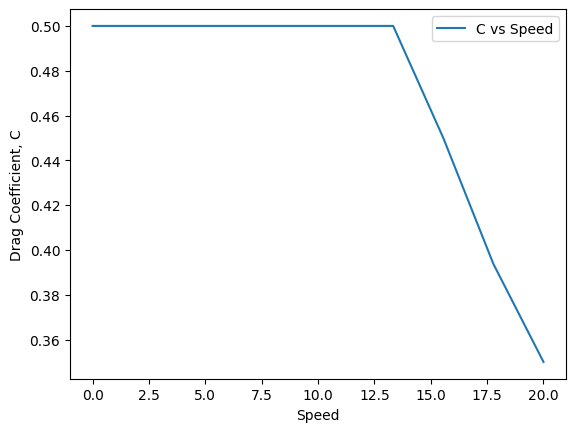

In [6]:
# make a plot of C versus speed, as speed ranges from 0 to 20
v = np.linspace(0,20,10)
C = np.zeros(10)

for i in range(len(v)):
  C[i] = drag_coeff(v[i])

# plotting the drag coefficient vs speed
plt.figure()
plt.plot(v,C,label='C vs Speed')
plt.xlabel('Speed')
plt.ylabel('Drag Coefficient, C')
plt.legend()

## Calculate function

Edit the cell below to construct your `calculate` function.  Use the comments in the cell below to guide your code development.

**IMPORTANT:**  make sure you have derived the full equation of motion before starting this part!

### Input Parameters

* club: integer value between 3 and 9, representing the club iron
* speed: launch speed in mph; the default value is 120 mph
* dt : time step in seconds; the default is 0.1 s
* spinFlag : use to turn spin on and off
* dragFlag : use to turn air resistance on and off
* windFlag : use to turn wind on and off
* randomFlag : use this to turn random noise on and off

### Returns
* t : list of time values (sec)
* x : list of x position values (m)
* y : list of y position values (m)
* z : list of z position values (m)
* vx : list of x velocity values (m/s)
* vy : list of y velocity values (m/s)
* vz : list of z velocity values (m/s)

In [45]:
def calculate(club=7,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False):
  """
  This function will calculate the arrays for position and velocity in the x,y, and z directions as
  a function of time
  """
  ################################
  # Convert input speed from mph to m/s
  ################################
  v0 = speed*mph2ms # approximately 100 mph

  ################################
  # Define club-dependent parameters
  ################################

  # get theta0_deg from the launch_angle dictionary
  theta0_deg = launch_angle[club]

  # assume the motion is in the x-y plane (no z component)
  phi0_deg = 0

  # get omega_rpm from the spin dictionary
  omega_rpm = spin[club]

  ################################
  # Add randomness to speed,angle, and spin
  # DON'T ADJUST THIS CODE
  ################################
  if randomFlag:
    v0 = np.random.normal(v0,.07*v0,1)[0]

    theta0_deg = np.random.normal(theta0_deg,1,1)[0]

    # add a little angle in the z direction
    phi0_deg = np.random.normal(phi0_deg,1,1)[0]

    omega_rpm = np.random.normal(omega_rpm,0.01*omega_rpm,1)[0]

  print(f"launch parameters: speed = {v0:.1f}, theta={theta0_deg:.1f}, spin={omega_rpm:.0f}")


  ################################
  # Convert theta and phi from deg to radians
  ################################
  theta0 = math.radians(theta0_deg)
  phi0 = math.radians(phi0_deg)

  ################################
  # convert omega from rpm to rad/s
  ################################
  omega_rad = omega_rpm * (2*np.pi / 60)

  ################################
  # Define initial conditions
  ################################
  # position variables: x0,y0,z0
  x0 = 0
  y0 = 0
  z0 = 0

  # initial velocities: v0x,v0y,v0z
  v0x = v0*np.cos(phi0)*np.cos(theta0)
  v0z = v0*np.sin(phi0)*np.cos(theta0)
  v0y = v0*np.sin(theta0)

  ################################
  # initialize the lists for x,y,z
  # and vx,vy,vz
  # and time, t
  ################################
  t = []

  x = []
  x.append(x0)

  y = []
  y.append(y0)

  z = []
  z.append(z0)

  vx = []
  vx.append(v0x)

  vy = []
  vy.append(v0y)

  vz = []
  vz.append(v0z)

  # set the initial value of the time list to zero

  t.append(0)

  ################################
  # Set initial value of i to 1
  ################################
  i = 1

  ################################
  # while loop for Euler calculation
  ################################
  while y[i-1] >= 0:

    # use euler method to calculate the new xnew,ynew,znew positions
    xnew = x[i-1] + vx[i-1]*dt
    ynew = y[i-1] + vy[i-1]*dt
    znew = z[i-1] + vz[i-1]*dt

    # append new values to the x,y,z lists
    x.append(xnew)
    y.append(ynew)
    z.append(znew)

    # calculate speed, the magnitude of the velocity vector
    speed = np.sqrt(vx[i-1]**2 + vy[i-1]**2 + vz[i-1]**2)

    # get wind velocity from function get_wind
    vx_wind,vy_wind,vz_wind = get_vwind(y[i-1],vmax=20,wind_direction=0)

    # calculate the magnitude of the wind velocity
    windspeed = (np.sqrt(vx_wind**2 + vy_wind**2 + vz_wind**2))

    # calculate the vector difference
    # this should be a vector np.array([x,y,z])
    vx_minus_wind = vx[i-1] - vx_wind
    vy_minus_wind = vy[i-1] - vy_wind
    vz_minus_wind = vz[i-1] - vz_wind

    # calculate the magnitude of v_minus_wind to get the total speed of the ball
    v_minus_wind_mag = np.sqrt(vx_minus_wind**2 + vy_minus_wind**2 + vz_minus_wind**2)

    # get coefficient for air resistance
    # use the v_minus_wind_mag as input into drag_coeff
    # calcute B2 = c*rhoair*np.pi*radius_ball**2
    B2 = 0.5*drag_coeff(v_minus_wind_mag)*rhoair*np.pi*r_golfball**2

    # Adjust parameters based on input flags
    if not dragFlag:
      B2 = 0
    if not spinFlag:
      omega_rad = 0
    if not windFlag:
      vx_wind,vy_wind,vz_wind = 0,0,0

    # calculate ax, x acceleration
    ax = 1/m*(-B2*(v_minus_wind_mag)*(vx_minus_wind) - S0*omega_rad*(vy[i-1] - vy_wind))
    # calculate ay, y acceleration
    ay = 1/m*(-m*g - B2 * (v_minus_wind_mag)*(vy_minus_wind) + S0*omega_rad*(vx[i-1]-vx_wind))
    # calculate az, z acceleration
    az = 1/m*(-B2*(v_minus_wind_mag)*(vz_minus_wind))


    # euler method for velocity
    # append new values of vx,vy,vz to their respective lists
    vx.append(vx[i-1] + ax*dt)
    vy.append(vy[i-1] + ay*dt)
    vz.append(vz[i-1] + az*dt)

    # add new time into time list
    tnew = t[i-1] + dt
    t.append(tnew)

    # increment i
    i += 1

  return t,x,y,z,vx,vy,vz

# Part 1: Calculate Trajectories With and Without Spin

* Use your calculate function to determine trajectories with and without spin.
* Plot y vs x for ball hit with same launch speed (100 mph) but with different irons.
* Which iron produces the longest range?  does this change when including spin?

Without spin, club 9 produces the longest range. However, when including spin, club 4 produces the longest range.

* Which iron produces the greatest height? does this change when including spin?

Without spin, club 9 also produces the greatest height. This is still true when including spin.

* Which iron is best matched to the distance required on the 12th hole (155 yards)?

When including spin, club 9 would prove to be best matched since it falls right before 150.



launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=24.0, spin=4800
launch parameters: speed = 44.4, theta=27.0, spin=5500
launch parameters: speed = 44.4, theta=30.0, spin=6000
launch parameters: speed = 44.4, theta=34.0, spin=6850
launch parameters: speed = 44.4, theta=38.0, spin=7700
launch parameters: speed = 44.4, theta=42.0, spin=8000

launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=24.0, spin=4800
launch parameters: speed = 44.4, theta=27.0, spin=5500
launch parameters: speed = 44.4, theta=30.0, spin=6000
launch parameters: speed = 44.4, theta=34.0, spin=6850
launch parameters: speed = 44.4, theta=38.0, spin=7700
launch parameters: speed = 44.4, theta=42.0, spin=8000


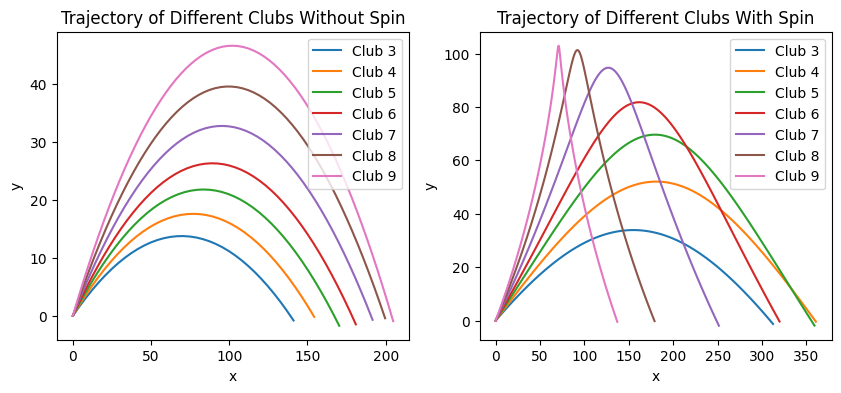

In [32]:
# Trajectory without Spin for different irons
t_nospin3,x_nospin3,y_nospin3,z_nospin3,vx_nospin3,vy_nospin3,vz_nospin3 = calculate(club=3,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin4,x_nospin4,y_nospin4,z_nospin4,vx_nospin4,vy_nospin4,vz_nospin4 = calculate(club=4,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin5,x_nospin5,y_nospin5,z_nospin5,vx_nospin5,vy_nospin5,vz_nospin5 = calculate(club=5,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin6,x_nospin6,y_nospin6,z_nospin6,vx_nospin6,vy_nospin6,vz_nospin6 = calculate(club=6,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin7,x_nospin7,y_nospin7,z_nospin7,vx_nospin7,vy_nospin7,vz_nospin7 = calculate(club=7,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin8,x_nospin8,y_nospin8,z_nospin8,vx_nospin8,vy_nospin8,vz_nospin8 = calculate(club=8,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)
t_nospin9,x_nospin9,y_nospin9,z_nospin9,vx_nospin9,vy_nospin9,vz_nospin9 = calculate(club=9,speed=100,dt=0.1,spinFlag=False,dragFlag=False,randomFlag=False,windFlag=False)

# Plotting trajectory without spin for different irons
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_nospin3,y_nospin3,label='Club 3')
plt.plot(x_nospin4,y_nospin4,label='Club 4')
plt.plot(x_nospin5,y_nospin5,label='Club 5')
plt.plot(x_nospin6,y_nospin6,label='Club 6')
plt.plot(x_nospin7,y_nospin7,label='Club 7')
plt.plot(x_nospin8,y_nospin8,label='Club 8')
plt.plot(x_nospin9,y_nospin9,label='Club 9')
plt.title('Trajectory of Different Clubs Without Spin')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

print()

# Trajectory with Spin
t_spin3,x_spin3,y_spin3,z_spin3,vx_spin3,vy_spin3,vz_spin3 = calculate(club=3,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin4,x_spin4,y_spin4,z_spin4,vx_spin4,vy_spin4,vz_spin4 = calculate(club=4,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin5,x_spin5,y_spin5,z_spin5,vx_spin5,vy_spin5,vz_spin5 = calculate(club=5,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin6,x_spin6,y_spin6,z_spin6,vx_spin6,vy_spin6,vz_spin6 = calculate(club=6,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin7,x_spin7,y_spin7,z_spin7,vx_spin7,vy_spin7,vz_spin7 = calculate(club=7,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin8,x_spin8,y_spin8,z_spin8,vx_spin8,vy_spin8,vz_spin8 = calculate(club=8,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)
t_spin9,x_spin9,y_spin9,z_spin9,vx_spin9,vy_spin9,vz_spin9 = calculate(club=9,speed=100,dt=0.1,spinFlag=True,dragFlag=False,randomFlag=False,windFlag=False)

# Plotting trajectory with spin for different irons
plt.subplot(1,2,2)
plt.plot(x_spin3,y_spin3,label='Club 3')
plt.plot(x_spin4,y_spin4,label='Club 4')
plt.plot(x_spin5,y_spin5,label='Club 5')
plt.plot(x_spin6,y_spin6,label='Club 6')
plt.plot(x_spin7,y_spin7,label='Club 7')
plt.plot(x_spin8,y_spin8,label='Club 8')
plt.plot(x_spin9,y_spin9,label='Club 9')
plt.title('Trajectory of Different Clubs With Spin')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Part 2: Calculate Trajectories With Spin and Air Resistance

* Your calculate function to take into account air resistance and spin.
* Plot y vs x for ball hit with same launch speed (100 mph) but with different irons
* Which iron produces the longest range?  does this change when including spin?

Without spin, club 9 produces the longest range. However, when including spin, club 4 produces the longest range.

* Which iron produces the greatest height? does this change when including spin?

Without spin, club 9 also produces the greatest height. This is still true when including spin.

* Which iron is best matched to the distance required on the 12th hole (155 yards)?

When including spin and air resistance, club 8 proves to be best matched because it falls slightly after 150.

launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=24.0, spin=4800
launch parameters: speed = 44.4, theta=27.0, spin=5500
launch parameters: speed = 44.4, theta=30.0, spin=6000
launch parameters: speed = 44.4, theta=34.0, spin=6850
launch parameters: speed = 44.4, theta=38.0, spin=7700
launch parameters: speed = 44.4, theta=42.0, spin=8000


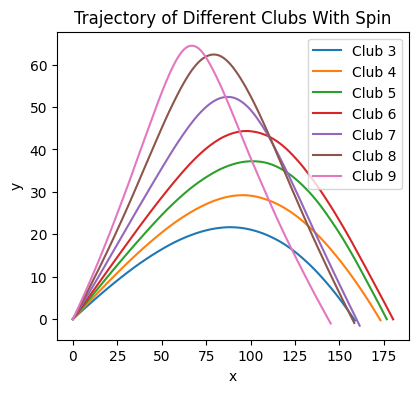

In [34]:
# Trajectories With Spin and Air Resistance
t_spinair3,x_spinair3,y_spinair3,z_spinair3,vx_spinair3,vy_spinair3,vz_spinair3 = calculate(club=3,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair4,x_spinair4,y_spinair4,z_spinair4,vx_spinair4,vy_spinair4,vz_spinair4 = calculate(club=4,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair5,x_spinair5,y_spinair5,z_spinair5,vx_spinair5,vy_spinair5,vz_spinair5 = calculate(club=5,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair6,x_spinair6,y_spinair6,z_spinair6,vx_spinair6,vy_spinair6,vz_spinair6 = calculate(club=6,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair7,x_spinair7,y_spinair7,z_spinair7,vx_spinair7,vy_spinair7,vz_spinair7 = calculate(club=7,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair8,x_spinair8,y_spinair8,z_spinair8,vx_spinair8,vy_spinair8,vz_spinair8 = calculate(club=8,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)
t_spinair9,x_spinair9,y_spinair9,z_spin9air,vx_spinair9,vy_spinair9,vz_spinair9 = calculate(club=9,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=False)

# Plotting trajectory with spin for different irons
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_spinair3,y_spinair3,label='Club 3')
plt.plot(x_spinair4,y_spinair4,label='Club 4')
plt.plot(x_spinair5,y_spinair5,label='Club 5')
plt.plot(x_spinair6,y_spinair6,label='Club 6')
plt.plot(x_spinair7,y_spinair7,label='Club 7')
plt.plot(x_spinair8,y_spinair8,label='Club 8')
plt.plot(x_spinair9,y_spinair9,label='Club 9')
plt.title('Trajectory of Different Clubs With Spin')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Part 3: Incorporating Wind!

### Overview
* One of the most challenging aspects of the 12th hole at Augusta is the wind.  
Therefore, in this section we will get to our final model for the golf ball that includes the effects of:
  * gravity
  * spin
  * air resistance, and
  * **wind**.

* We will model the wind as coming from behind the golfer, heading in the $+x$ direction.  We will assume a gust speed of 15 m/s, although the frequency of the gusts and the actual speed are randomized a bit.
* I have coded this part for you, so you will just have to call `get_vwind` in the `calculate` function and incorporate its effects into the acceleration vector.

### Directions
* Select one club from the Part 2 that best matches the range needed to reach the green on the 12th hole (155 yards = 141 m).

* Plot the geometry of the hole using the following code:
```python
plt.figure(figsize=(10,3))
plot_hole12()
```
* Then create a loop to plot 10 different trajectories for the same club and launch speed (again starting with 100 mph).  You can plot the trajectory using the following code:
```python
show_drive(x,z)
```

* Be sure to set `windFlag=True` when calling your calculate function.

* The wind speed and direction will be random each time, so you will see scatter in the resulting trajectories.

### Questions

* How do the trajectories change as a result of the gusting wind?

As a result of the gusting wind, the trajectories are altered. Depending on the direction of the gust of wind, the ball will fall short of the green or carry further to the back of the green. However, it seems that it stays on a pretty consistently straight path. This is based off of using club 8.

* How accurate are your drives?  What fraction lands on the green?

The drives are fairy accurate. The fraction that lands on the green is about 7/10 of the shots. This is also based on using club 8.

* Can you make any adjustments to your swing (club or speed) to improve the accuracy of your drives?

By changing from club 8 to club 3 I was able to improve the accuracy significantly. Because the gust of wind seemed to make the ball fall short of the green, I switched to a club that made the ball go a bit further. As a result, all of the attempts landed on the green.

launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000
launch parameters: speed = 44.4, theta=21.0, spin=4000


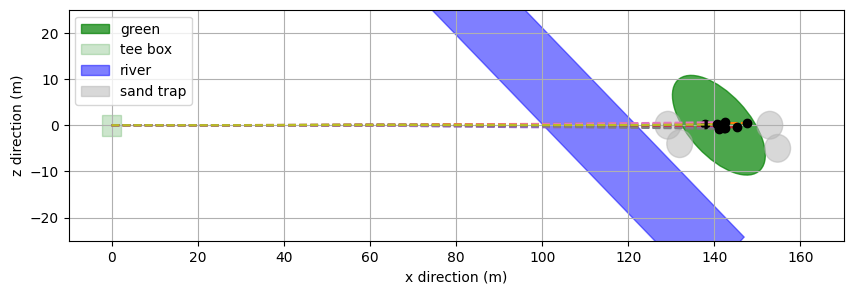

In [43]:
# your code here
# plug in correct for hole 12 geometry
plt.figure(figsize=(10,3))
plot_hole12()

# plot using club 3 for highest accuracy
for i in range(1,10):
  t_spinair,x_spinair,y_spinair,z_spinair,vx_spinair,vy_spinair,vz_spinair = calculate(club=3,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=False,windFlag=True)
  show_drive(x_spinair,z_spinair)

# Part 4: Adding Variations to the Initial Launch Parameters

* PGA and LPGA players are incredibly precise, but there is still some variation in the speed, spin, launch angle of the ball.
* To simulate these variations, set `randomFlag=True` when calling your calculate function.  This will add some noise to the initial parameters.


### Questions

* How do the trajectories change as a result of adding some variation to the launch speed and direction?

By adding some variation to the launch speed and direction, the trajectories go off to the left or the right a bit more.

* Is the accuracy of the drives affected?  

For the most part, the accuracy of the drives landing on the green is not affected. All of the shots still land on the green.

* The code I provided (in your calculate function) adds 1 degree of randomness to the direction and 1% of randomness to the launch speed.  This is not much variation!  
* Try adjusting these to something more realistic for an amateur golfer, maybe 5-10%.  Does an amateur have any hope of hitting the green??

By changing the percentage of randomness to 7%, an amateur golfer has nearly no hope of hitting the green.


launch parameters: speed = 47.7, theta=22.3, spin=4015
launch parameters: speed = 40.3, theta=20.3, spin=3916
launch parameters: speed = 47.5, theta=20.8, spin=4042
launch parameters: speed = 43.1, theta=20.4, spin=3930
launch parameters: speed = 47.5, theta=22.6, spin=3940
launch parameters: speed = 43.0, theta=20.2, spin=4063
launch parameters: speed = 49.1, theta=21.5, spin=3916
launch parameters: speed = 41.4, theta=20.1, spin=4021
launch parameters: speed = 49.2, theta=21.0, spin=3992


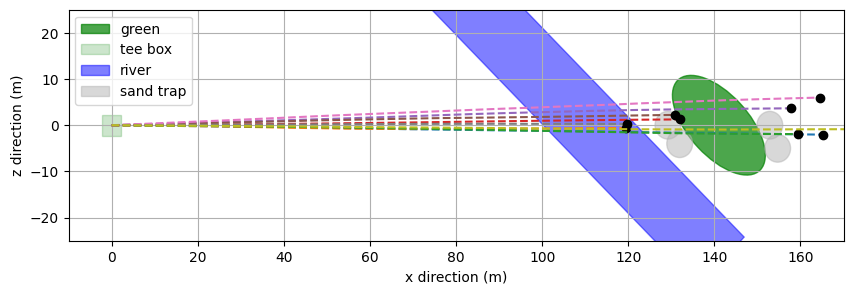

In [46]:
# your code here
# plug in correct for hole 12 geometry (using 7% randomness for launch speed)
plt.figure(figsize=(10,3))
plot_hole12()

# plot using club 3 and 7% randomness for an amateur golfer
for i in range(1,10):
  t_spinair,x_spinair,y_spinair,z_spinair,vx_spinair,vy_spinair,vz_spinair = calculate(club=3,speed=100,dt=0.1,spinFlag=True,dragFlag=True,randomFlag=True,windFlag=True)
  show_drive(x_spinair,z_spinair)

# Reference Values

You don't need to do anything in this section. I am just listing some of the references that I used and values that we are using in this notebook.

### Mass of golf ball

$m = 45$ g

### Launch speeds

We will assume a launch speed of $\sim$100 mph

https://medium.com/@thegolfhype.com/how-fast-does-the-average-golf-ball-travel-17edc632e10e



### Loft/launch angle of irons


https://golfbit.com/golf-club-lofts-degree-wedge-iron-wood-driver

https://www.graff.golf/the-club/how-much-spin-should-each-golf-club-produce




### Direction of Spin Vectors

| spin | direction of ω |
|-----|------|
| backspin | $+\hat{z}$|
| forward spin | $-\hat{z}$|
| CCW looking down on ball | $+\hat{y}$|
| CW looking down on ball | $-\hat{y}$|
| CW looking at back of ball | $+\hat{x}$|
| CCW looing at back of ball | $-\hat{x}$|

